In [1]:
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch import ProjectedGradientDescentPyTorch
from art.estimators.classification.pytorch import PyTorchClassifier
from art.attacks.evasion.auto_attack import AutoAttack
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

from art.utils import load_dataset

(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
i = 10
x_train = x_train[:i, :].transpose(0, 3, 1, 2).astype('float32')
x_test = x_test[:i, :].transpose(0, 3, 1, 2).astype('float32')
y_train = y_train[:i, :].astype('float32')
y_test = y_test[:i, :].astype('float32')

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

path = '../'

class Model(torch.nn.Module):
    """
    Create model for pytorch.
    Here the model does not use maxpooling. Needed for certification tests.
    """

    def __init__(self):
        super(Model, self).__init__()

        self.conv = torch.nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(3, 3)
        )

        self.fullyconnected = torch.nn.Linear(in_features=1600, out_features=10)

        self.relu = torch.nn.ReLU()

        w_conv2d = np.load(
            os.path.join(
                os.path.dirname(path),
                "utils/resources/models",
                "W_CONV2D_NO_MPOOL_CIFAR10.npy",
            )
        )
        b_conv2d = np.load(
            os.path.join(
                os.path.dirname(path),
                "utils/resources/models",
                "B_CONV2D_NO_MPOOL_CIFAR10.npy",
            )
        )
        w_dense = np.load(
            os.path.join(
                os.path.dirname(path),
                "utils/resources/models",
                "W_DENSE_NO_MPOOL_CIFAR10.npy",
            )
        )
        b_dense = np.load(
            os.path.join(
                os.path.dirname(path),
                "utils/resources/models",
                "B_DENSE_NO_MPOOL_CIFAR10.npy",
            )
        )

        self.conv.weight = torch.nn.Parameter(torch.Tensor(w_conv2d))
        self.conv.bias = torch.nn.Parameter(torch.Tensor(b_conv2d))
        self.fullyconnected.weight = torch.nn.Parameter(torch.Tensor(w_dense))
        self.fullyconnected.bias = torch.nn.Parameter(torch.Tensor(b_dense))

    # pylint: disable=W0221
    # disable pylint because of API requirements for function
    def forward(self, x):
        """
        Forward function to evaluate the model
        :param x: Input to the model
        :return: Prediction of the model
        """
        x = self.conv(x)
        x = self.relu(x)
        x = x.reshape(-1, 1600)
        x = self.fullyconnected(x)
        # x = torch.nn.functional.softmax(x, dim=1) # removed to return logits
        return x

# Define the network
model = Model()

# Define a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Get classifier
ptc = PyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32), nb_classes=10, clip_values=(0, 1), channels_first=False
)
ptc_preds = ptc.predict(x_train)

In [2]:
n = 20
attacks = []

# create multiple values for max_iter
max_iter = [i+1 for i in list(range(n))]
print('max_iter values:', max_iter)

# create multiple values for eps
eps_steps = [round(float(i/100+0.001), 3) for i in list(range(n))]
print('eps_step values:', eps_steps)

for i, eps_step in enumerate(eps_steps):
    attacks.append(
        ProjectedGradientDescentPyTorch(
            estimator=ptc,
            norm=np.inf,
            eps=0.1,
            eps_step=eps_step,
            max_iter=10,
            targeted=False,
            batch_size=32,
            verbose=False
        )
    )
    attacks.append(
        ProjectedGradientDescentPyTorch(
            estimator=ptc,
            norm=np.inf,
            eps=0.1,
            max_iter=max_iter[i],
            targeted=False,
            batch_size=32,
            verbose=False
        )
    )
    
print('Number of attacks:', len(attacks))
open_source_attack = AutoAttack(estimator=ptc, attacks=attacks, targeted=True, in_parallel=False)

a = [2 for i in x_train]
b = np.zeros((len(a), 10)).astype(np.float32)
b[np.arange(len(a)), a] = float(1)
b = b.astype(np.float32)

x_adv = open_source_attack.generate(x=x_train, y=y_train)

max_iter values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
eps_step values: [0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171, 0.181, 0.191]
Number of attacks: 40
attack <art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch.ProjectedGradientDescentPyTorch object at 0x103664250>
attack <art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch.ProjectedGradientDescentPyTorch object at 0x1036643d0>
attack <art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch.ProjectedGradientDescentPyTorch object at 0x1036640d0>
attack <art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch.ProjectedGradientDescentPyTorch object at 0x10383d250>
attack <art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch.ProjectedGradientDescentPyTorch object at 0x10383d040>
attack

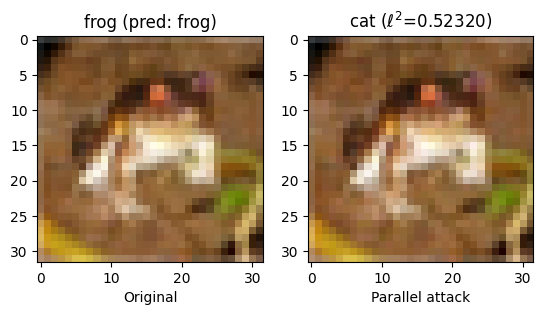

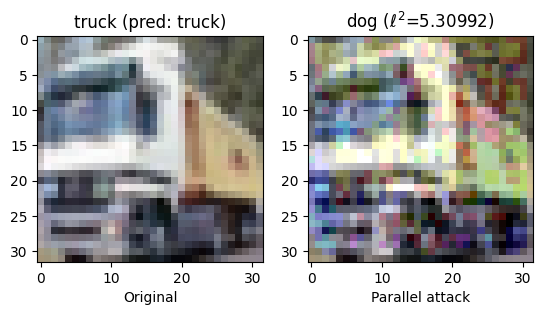

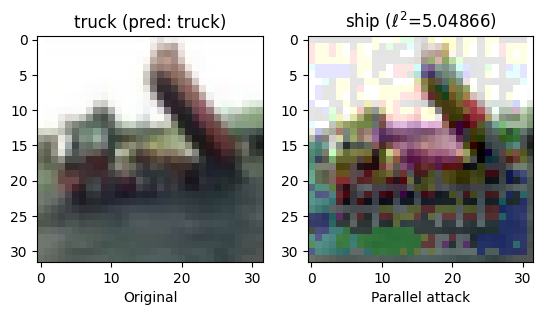

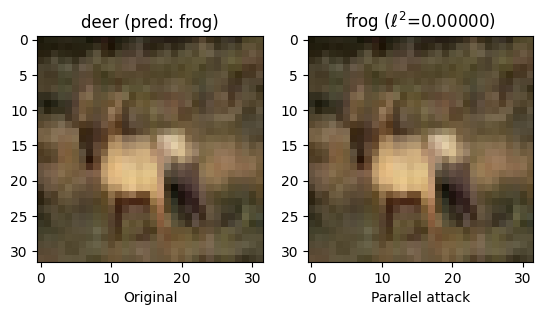

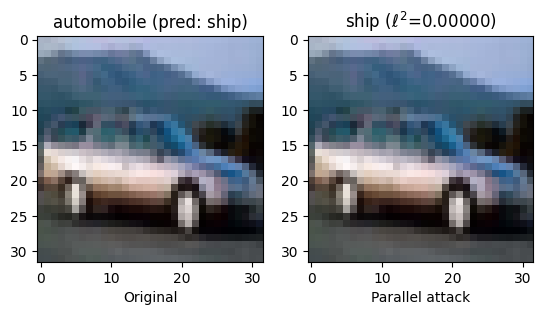

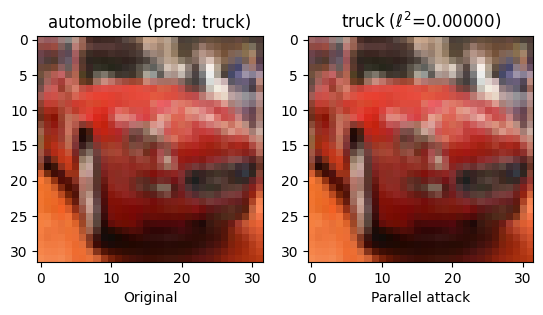

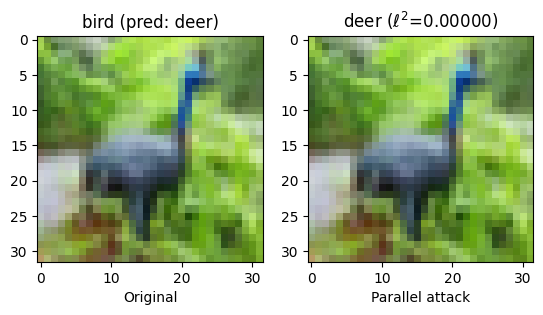

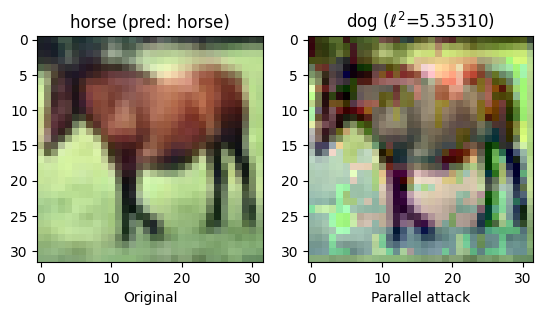

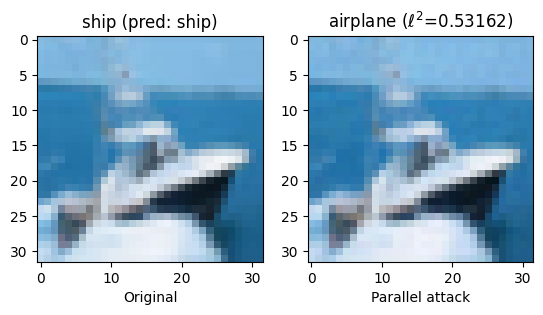

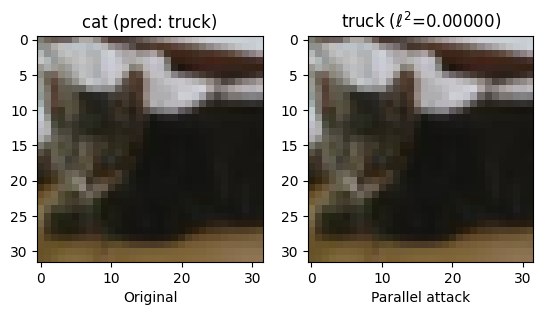

In [6]:
import matplotlib.pyplot as plt

for i in range(len(x_train)):
    f, ax = plt.subplots(1,2)

    perturbation = np.linalg.norm(x_train[[i]] - x_adv[[i]])

    # ax[0].set_title(f'{labels[np.argmax(ptc.predict(x_train[i]))]}')
    ax[0].set_title(f'{labels[np.argmax(y_train[[i]])]} (pred: {labels[np.argmax(ptc.predict(x_train[i]))]})')
    ax[0].imshow(x_train[i].transpose(1,2,0))
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'{labels[np.argmax(ptc.predict(x_adv[i]))]} ($\\ell ^{2}$={perturbation:.5f})')
    ax[1].imshow(x_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Parallel attack')

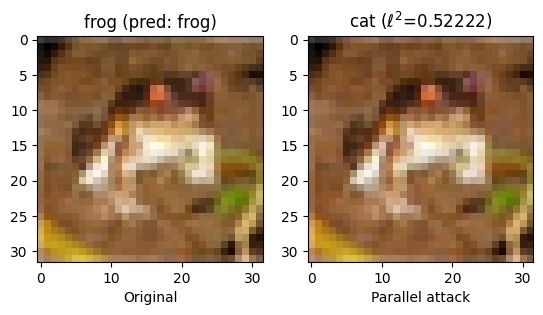

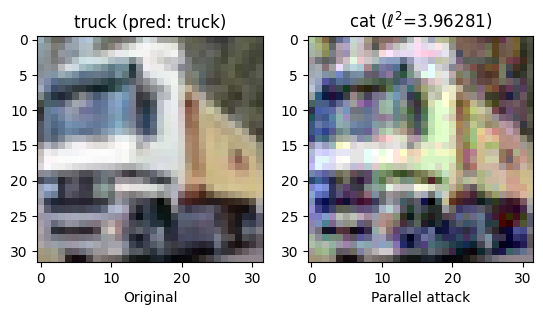

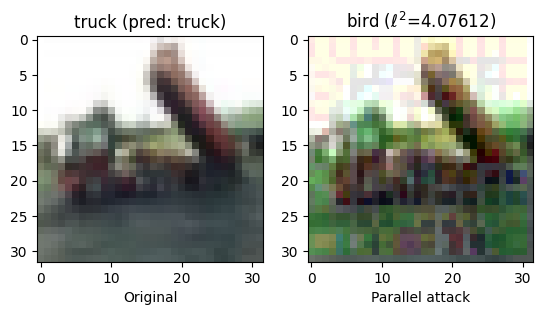

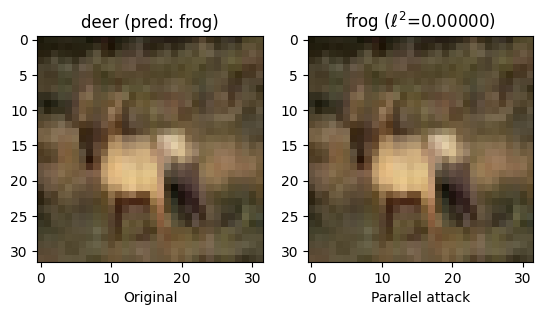

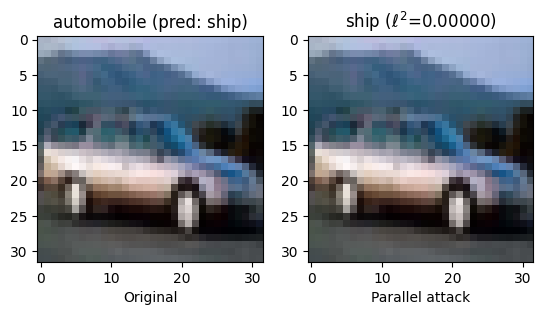

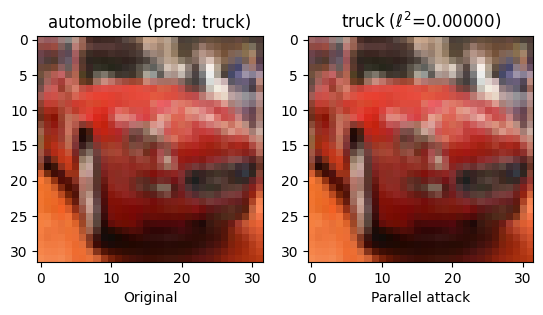

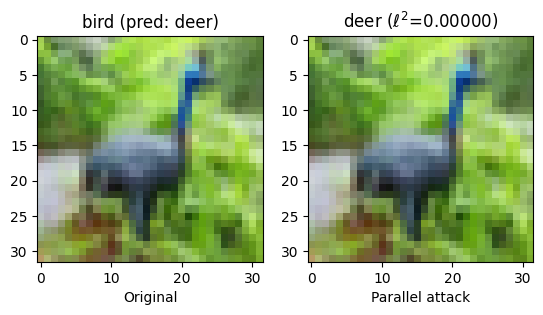

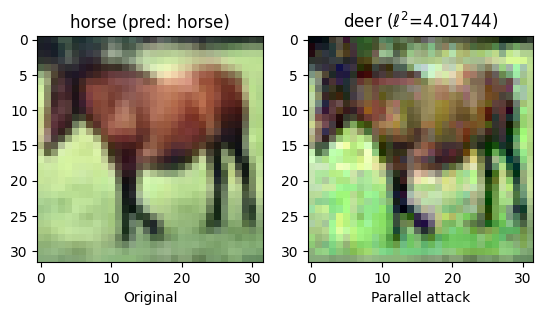

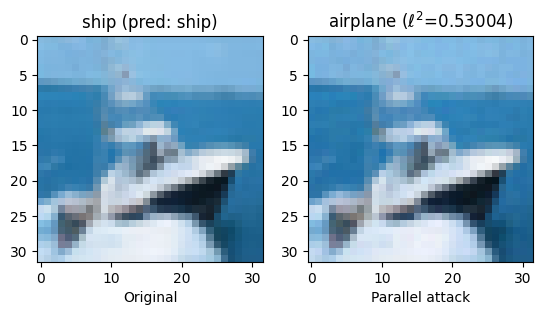

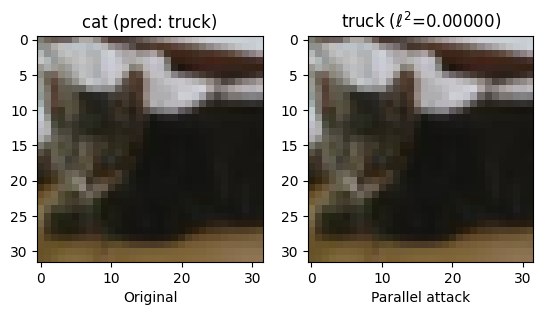

In [4]:
import matplotlib.pyplot as plt

for i in range(len(x_train)):
    f, ax = plt.subplots(1,2)

    perturbation = np.linalg.norm(x_train[[i]] - x_adv[[i]])

    # ax[0].set_title(f'{labels[np.argmax(ptc.predict(x_train[i]))]}')
    ax[0].set_title(f'{labels[np.argmax(y_train[[i]])]} (pred: {labels[np.argmax(ptc.predict(x_train[i]))]})')
    ax[0].imshow(x_train[i].transpose(1,2,0))
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'{labels[np.argmax(ptc.predict(x_adv[i]))]} ($\\ell ^{2}$={perturbation:.5f})')
    ax[1].imshow(x_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Parallel attack')

In [3]:
from art.attacks.evasion.auto_attack import AutoAttack, AutoProjectedGradientDescent
from art.estimators.classification.pytorch import PyTorchClassifier
import numpy as np
import os
from tests.utils import load_dataset
import torch
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch import ProjectedGradientDescentPyTorch


def get_image_classifier_pt(from_logits=False, load_init=True, use_maxpool=True):
    """
    Standard PyTorch classifier for unit testing.

    :param from_logits: Flag if model should predict logits (True) or probabilities (False).
    :type from_logits: `bool`
    :param load_init: Load the initial weights if True.
    :type load_init: `bool`
    :param use_maxpool: If to use a classifier with maxpool or not
    :type use_maxpool: `bool`
    :return: PyTorchClassifier
    """
    import torch

    path = '../'

    if use_maxpool:

        class Model(torch.nn.Module):
            """
            Create model for pytorch.

            The weights and biases are identical to the TensorFlow model in get_classifier_tf().
            """

            def __init__(self):
                super(Model, self).__init__()

                self.conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=7)
                self.relu = torch.nn.ReLU()
                self.pool = torch.nn.MaxPool2d(4, 4)
                self.fullyconnected = torch.nn.Linear(25, 10)

                if load_init:
                    w_conv2d = np.load(
                        os.path.join(
                            os.path.dirname(path), "utils/resources/models", "W_CONV2D_MNIST.npy"
                        )
                    )
                    b_conv2d = np.load(
                        os.path.join(
                            os.path.dirname(path), "utils/resources/models", "B_CONV2D_MNIST.npy"
                        )
                    )
                    w_dense = np.load(
                        os.path.join(
                            os.path.dirname(path), "utils/resources/models", "W_DENSE_MNIST.npy"
                        )
                    )
                    b_dense = np.load(
                        os.path.join(
                            os.path.dirname(path), "utils/resources/models", "B_DENSE_MNIST.npy"
                        )
                    )

                    w_conv2d_pt = w_conv2d.reshape((1, 1, 7, 7))

                    self.conv.weight = torch.nn.Parameter(torch.Tensor(w_conv2d_pt))
                    self.conv.bias = torch.nn.Parameter(torch.Tensor(b_conv2d))
                    self.fullyconnected.weight = torch.nn.Parameter(torch.Tensor(np.transpose(w_dense)))
                    self.fullyconnected.bias = torch.nn.Parameter(torch.Tensor(b_dense))

            # pylint: disable=W0221
            # disable pylint because of API requirements for function
            def forward(self, x):
                """
                Forward function to evaluate the model
                :param x: Input to the model
                :return: Prediction of the model
                """
                x = self.conv(x)
                x = self.relu(x)
                x = self.pool(x)
                x = x.reshape(-1, 25)
                x = self.fullyconnected(x)
                if not from_logits:
                    x = torch.nn.functional.softmax(x, dim=1)
                return x

    else:

        class Model(torch.nn.Module):
            """
            Create model for pytorch.
            Here the model does not use maxpooling. Needed for certification tests.
            """

            def __init__(self):
                super(Model, self).__init__()

                self.conv = torch.nn.Conv2d(
                    in_channels=1, out_channels=16, kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(3, 3)
                )

                self.fullyconnected = torch.nn.Linear(in_features=1296, out_features=10)

                self.relu = torch.nn.ReLU()

                if load_init:
                    w_conv2d = np.load(
                        os.path.join(
                            os.path.dirname(path),
                            "utils/resources/models",
                            "W_CONV2D_NO_MPOOL_MNIST.npy",
                        )
                    )
                    b_conv2d = np.load(
                        os.path.join(
                            os.path.dirname(path),
                            "utils/resources/models",
                            "B_CONV2D_NO_MPOOL_MNIST.npy",
                        )
                    )
                    w_dense = np.load(
                        os.path.join(
                            os.path.dirname(path),
                            "utils/resources/models",
                            "W_DENSE_NO_MPOOL_MNIST.npy",
                        )
                    )
                    b_dense = np.load(
                        os.path.join(
                            os.path.dirname(path),
                            "utils/resources/models",
                            "B_DENSE_NO_MPOOL_MNIST.npy",
                        )
                    )

                    self.conv.weight = torch.nn.Parameter(torch.Tensor(w_conv2d))
                    self.conv.bias = torch.nn.Parameter(torch.Tensor(b_conv2d))
                    self.fullyconnected.weight = torch.nn.Parameter(torch.Tensor(w_dense))
                    self.fullyconnected.bias = torch.nn.Parameter(torch.Tensor(b_dense))

            # pylint: disable=W0221
            # disable pylint because of API requirements for function
            def forward(self, x):
                """
                Forward function to evaluate the model
                :param x: Input to the model
                :return: Prediction of the model
                """
                x = self.conv(x)
                x = self.relu(x)
                x = x.reshape(-1, 1296)
                x = self.fullyconnected(x)
                if not from_logits:
                    x = torch.nn.functional.softmax(x, dim=1)
                return x

    # Define the network
    model = Model()

    # Define a loss function and optimizer
    loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Get classifier
    ptc = PyTorchClassifier(
        model=model, loss=loss_fn, optimizer=optimizer, input_shape=(1, 28, 28), nb_classes=10, clip_values=(0, 1)
    )

    return ptc

# Load MNIST data
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist), _, _ = load_dataset('mnist')

x_train_mnist = np.reshape(x_train_mnist, (x_train_mnist.shape[0],) + (1, 28, 28)).astype(np.float32)
x_test_mnist = np.reshape(x_test_mnist, (x_test_mnist.shape[0],) + (1, 28, 28)).astype(np.float32)

n_train = 10
n_test = 10
x_train_mnist = x_train_mnist[:n_train]
y_train_mnist = y_train_mnist[:n_train]
x_test_mnist = x_test_mnist[:n_test]
y_test_mnist = y_test_mnist[:n_test]

classifier = get_image_classifier_pt(from_logits=True)

In [4]:
from art.attacks.evasion.deepfool import DeepFool
from art.attacks.evasion.square_attack import SquareAttack
import pytest

In [5]:
tmp = np.array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
                ,[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
                ,[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
                ,[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
                ,[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
                ,[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
                ,[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
                ,[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
                ,[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])


In [8]:

norm = np.inf
eps = 0.3
eps_step = 0.1
batch_size = 32
sa = SquareAttack(estimator=classifier, norm=norm, max_iter=5000, eps=eps, p_init=0.8, nb_restarts=5, verbose=False,)
sa.targeted = None
adv = sa.generate(x_train_mnist, tmp)
for i, j in enumerate(x_train_mnist):
    print('p', np.linalg.norm(x_train_mnist[i] - adv[i]))
    print(np.argmax(classifier.predict(adv[i])))
    print(np.argmax(classifier.predict(x_train_mnist[i])))
    print('---')

---------------Setting


ValueError: You cannot set targeted for this attack.

In [5]:
norm = np.inf
eps = 0.3
eps_step = 0.1
batch_size = 32

attacks = list()
attacks.append(
    AutoProjectedGradientDescent(
        estimator=classifier,
        norm=norm,
        eps=eps,
        eps_step=eps_step,
        max_iter=100,
        targeted=True,
        nb_random_init=5,
        batch_size=batch_size,
        loss_type="cross_entropy",
        verbose=False,
    )
)
attacks.append(
    AutoProjectedGradientDescent(
        estimator=classifier,
        norm=norm,
        eps=eps,
        eps_step=eps_step,
        max_iter=100,
        targeted=False,
        nb_random_init=5,
        batch_size=batch_size,
        loss_type="difference_logits_ratio",
        verbose=False,
    )
)
attacks.append(DeepFool(classifier=classifier, max_iter=100, epsilon=1e-6, nb_grads=3, batch_size=batch_size, verbose=False,))
# attacks.append(DeepFool(classifier=classifier, max_iter=200, epsilon=1e-2, nb_grads=7, batch_size=batch_size, verbose=False,))
sa = SquareAttack(estimator=classifier, norm=norm, max_iter=5000, eps=eps, p_init=0.8, nb_restarts=5, verbose=False,)

attacks.append(sa)

# First test with defined_attack_only=False
attack = AutoAttack(
    estimator=classifier,
    norm=norm,
    eps=eps,
    eps_step=eps_step,
    attacks=attacks,
    batch_size=batch_size,
    estimator_orig=None,
    targeted=False,
    in_parallel=True,
)

x_train_mnist_adv = attack.generate(x=x_train_mnist, y=y_train_mnist)

assert np.mean(np.abs(x_train_mnist_adv - x_train_mnist)) == pytest.approx(0.0182, abs=0.105)
assert np.max(np.abs(x_train_mnist_adv - x_train_mnist)) == pytest.approx(0.3, abs=0.05)


Breaking after 1 restarts as sample is robust
y_pred 7
y [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
39828 square attack y pred labels [7 1]
39828 square attack y robust [4 4]
39828 square attack perturb 0: 5.6678114
39828 square attack perturb 1: 7.706458


/Users/kieranfraser/git/personal/art/env/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/kieranfraser/git/personal/art/env/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/kieranfraser/git/personal/art/env/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/kieranfraser/git/personal/art/env/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: 

In [5]:
import inspect 
'targeted' in inspect.signature(attacks[0].__init__).parameters.keys()

True

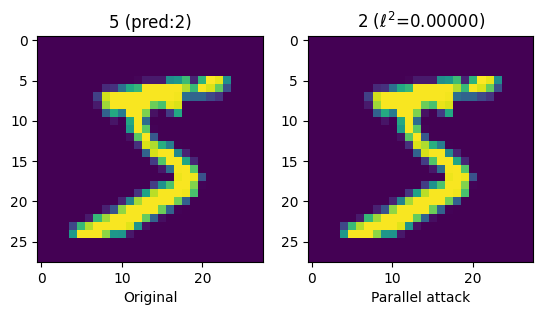

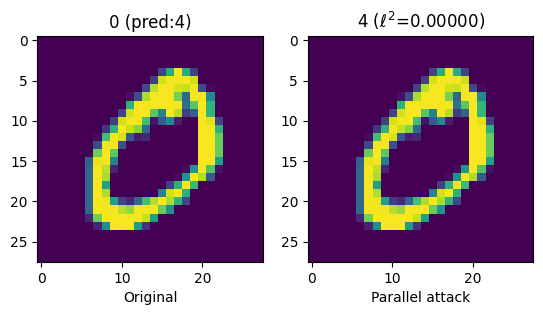

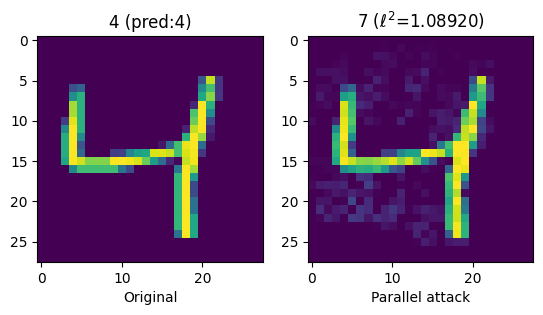

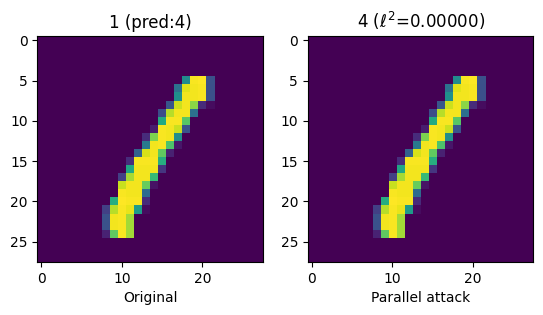

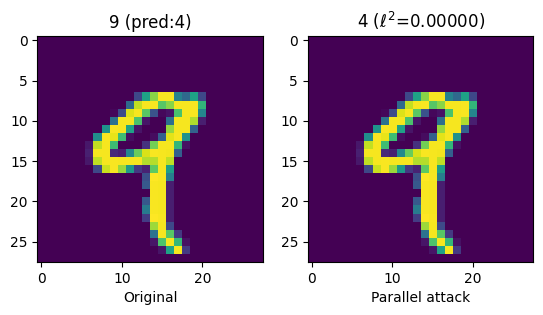

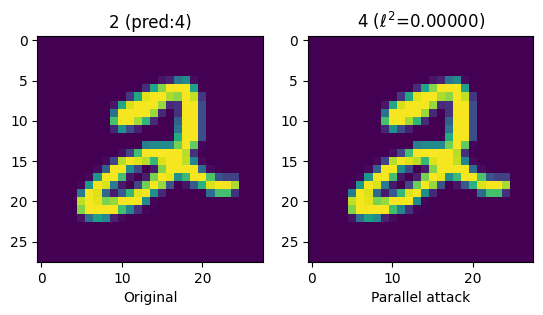

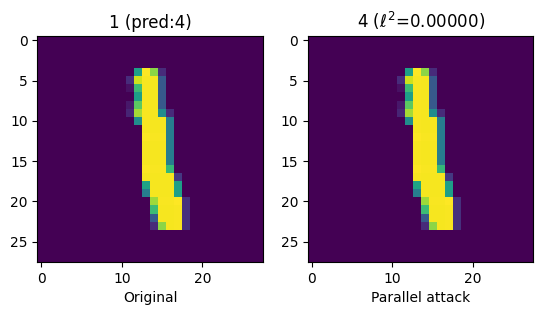

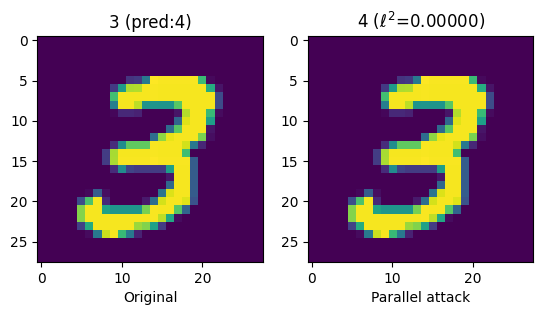

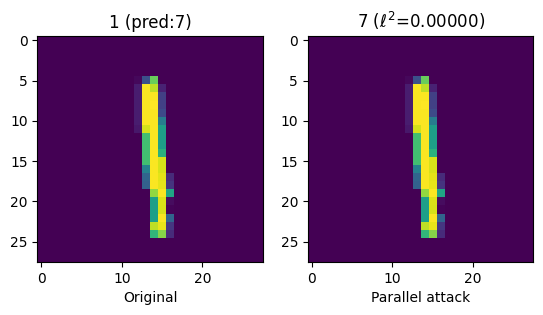

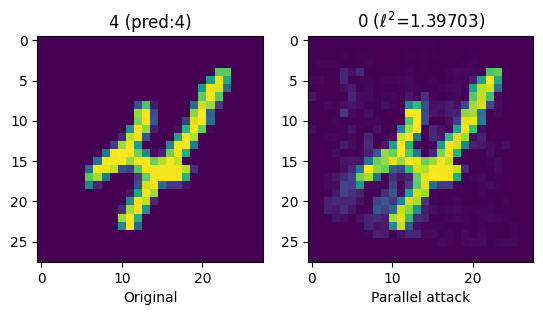

In [6]:
import matplotlib.pyplot as plt

labels = [0,1,2,3,4,5,6,7,8,9]
for i in range(len(x_train_mnist)):
    f, ax = plt.subplots(1,2)

    perturbation = np.linalg.norm(x_train_mnist[[i]] - x_train_mnist_adv[[i]])

    ax[0].set_title(f'{labels[np.argmax(y_train_mnist[[i]])]} (pred:{labels[np.argmax(classifier.predict(x_train_mnist[i]))]})')
    ax[0].imshow(x_train_mnist[i].transpose(1,2,0))
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'{labels[np.argmax(classifier.predict(x_train_mnist_adv[i]))]} ($\\ell ^{2}$={perturbation:.5f})')
    ax[1].imshow(x_train_mnist_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Parallel attack')

In [8]:
# Then test with defined_attack_only=True
attack = AutoAttack(
    estimator=classifier,
    norm=norm,
    eps=eps,
    eps_step=eps_step,
    attacks=attacks,
    batch_size=batch_size,
    estimator_orig=None,
    targeted=True,
    in_parallel=True,
)

x_train_mnist_adv = attack.generate(x=x_train_mnist, y=y_train_mnist)

# assert np.mean(x_train_mnist_adv - x_train_mnist) == pytest.approx(0.0179, abs=0.0075)
# assert np.max(np.abs(x_train_mnist_adv - x_train_mnist)) == pytest.approx(eps, abs=0.005)

attack <art.attacks.evasion.auto_projected_gradient_descent.AutoProjectedGradientDescent object at 0x2d71ba190>
attack <art.attacks.evasion.auto_projected_gradient_descent.AutoProjectedGradientDescent object at 0x2d71ba940>
attack <art.attacks.evasion.deepfool.DeepFool object at 0x104b07820>
attack <art.attacks.evasion.square_attack.SquareAttack object at 0x2d71ba8b0>
Breaking after 1 restarts as sample is robust
y_pred 0
y [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
39862 square attack y pred labels [0 1]
39862 square attack y robust [4 4]
39862 square attack perturb 0: 6.3856673
39862 square attack perturb 1: 7.6713424
Breaking after 0 restarts as sample is robust
y_pred 14
y [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
39862 square attack y pred labels [4 4]
39862 square attack y robust [0 0]
39862 square attack perturb 0: 0.0
39862 square attack perturb 1: 0.0
Breaking after 0 restarts as sample is robust
y_pred 14
y [[0. 1. 0. 0. 0. 0. 

/Users/kieranfraser/git/personal/art/env/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/kieranfraser/git/personal/art/env/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


In [140]:
perturbations = []
is_robust = []
for img_idx in range(len(x_train_mnist)):
    perturbations.append(np.array([ np.linalg.norm( x_train_mnist[img_idx] - i[0][img_idx]) for i in results]))
    is_robust.append([ i[1][img_idx] for i in results])
'''perturbations = np.array(perturbations)
is_robust = np.array(is_robust)
best_attacks = np.argmin(np.where(np.invert(is_robust), perturbations, np.inf),axis=1)
x_adv = np.concatenate([results[best_attacks[img]][0][[img]] for img in range(len(x_train_mnist))])'''

'perturbations = np.array(perturbations)\nis_robust = np.array(is_robust)\nbest_attacks = np.argmin(np.where(np.invert(is_robust), perturbations, np.inf),axis=1)\nx_adv = np.concatenate([results[best_attacks[img]][0][[img]] for img in range(len(x_train_mnist))])'

array([5.1072598, 4.216456 , 1.0891968, 7.243049 , 4.8067555, 5.289586 ,
       5.1296964, 5.117143 , 0.       , 0.       , 4.8041625, 5.074407 ,
       5.074194 , 4.7415414, 4.9629745, 5.2114196, 4.562575 , 0.       ,
       0.       , 5.1315303, 5.4712963, 0.       , 1.0891968, 1.0891968,
       1.0891968, 1.0891968, 1.0891968, 1.0891968, 0.       , 1.0891968,
       1.0891968, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       ], dtype=float32)

In [102]:
i[0][img_idx].shape

(1, 28, 28)

In [99]:
x_train_mnist[0].shape

(1, 28, 28)

In [104]:
np.linalg.norm( x_train_mnist[img_idx] - i[0][img_idx])

0.0

In [139]:
adv, is_r = results[22]
for i in range(adv.shape[0]):
    p = np.linalg.norm( x_train_mnist[i] - adv[i])
    print(p)

0.0
0.0
1.0891968
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [144]:
perturbations[2]

array([5.1072598, 4.216456 , 1.0891968, 7.243049 , 4.8067555, 5.289586 ,
       5.1296964, 5.117143 , 0.       , 0.       , 4.8041625, 5.074407 ,
       5.074194 , 4.7415414, 4.9629745, 5.2114196, 4.562575 , 0.       ,
       0.       , 5.1315303, 5.4712963, 0.       , 1.0891968, 1.0891968,
       1.0891968, 1.0891968, 1.0891968, 1.0891968, 0.       , 1.0891968,
       1.0891968, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       ], dtype=float32)

In [148]:
for attack, i in enumerate(results):
    p = np.linalg.norm( x_train_mnist[2] - i[0][2])
    print(f'{attack}, {p}, {i[1][2]}, {np.argmax(classifier.predict(i[0][2]))==np.argmax(y_train_mnist[2])}')
    # print('is robust', i[1][2])

0, 5.107259750366211, False, False
1, 4.216455936431885, False, False
2, 1.089196801185608, False, False
3, 7.243049144744873, False, False
4, 4.806755542755127, False, False
5, 5.289586067199707, False, False
6, 5.129696369171143, False, False
7, 5.117143154144287, False, False
8, 0.0, True, True
9, 0.0, True, True
10, 4.804162502288818, False, False
11, 5.07440710067749, False, False
12, 5.074193954467773, False, False
13, 4.741541385650635, False, False
14, 4.962974548339844, False, False
15, 5.211419582366943, False, False
16, 4.562574863433838, False, False
17, 0.0, True, True
18, 0.0, True, True
19, 5.131530284881592, False, False
20, 5.471296310424805, False, False
21, 0.0, True, True
22, 1.089196801185608, False, False
23, 1.089196801185608, False, False
24, 1.089196801185608, False, False
25, 1.089196801185608, False, False
26, 1.089196801185608, False, False
27, 1.089196801185608, False, False
28, 0.0, True, True
29, 1.089196801185608, False, False
30, 1.089196801185608, Fals

In [147]:
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [87]:
np.where(np.invert(is_robust), perturbations, np.inf)[2]

array([5.1072598, 4.216456 , 1.0891968, 7.243049 , 4.8067555, 5.289586 ,
       5.1296964, 5.117143 ,       inf,       inf, 4.8041625, 5.074407 ,
       5.074194 , 4.7415414, 4.9629745, 5.2114196, 4.562575 ,       inf,
             inf, 5.1315303, 5.4712963,       inf, 1.0891968, 1.0891968,
       1.0891968, 1.0891968, 1.0891968, 1.0891968,       inf, 1.0891968,
       1.0891968, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       ], dtype=float32)

In [89]:
perturbations[2]

array([5.1072598, 4.216456 , 1.0891968, 7.243049 , 4.8067555, 5.289586 ,
       5.1296964, 5.117143 , 0.       , 0.       , 4.8041625, 5.074407 ,
       5.074194 , 4.7415414, 4.9629745, 5.2114196, 4.562575 , 0.       ,
       0.       , 5.1315303, 5.4712963, 0.       , 1.0891968, 1.0891968,
       1.0891968, 1.0891968, 1.0891968, 1.0891968, 0.       , 1.0891968,
       1.0891968, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       ], dtype=float32)

In [94]:
is_robust[2]

array([False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False,  True,
        True, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False])

In [81]:
best_attacks

array([ 0,  0, 31,  0,  0,  0,  0,  0,  0, 31])

In [85]:
perturbations[2]

array([5.1072598, 4.216456 , 1.0891968, 7.243049 , 4.8067555, 5.289586 ,
       5.1296964, 5.117143 , 0.       , 0.       , 4.8041625, 5.074407 ,
       5.074194 , 4.7415414, 4.9629745, 5.2114196, 4.562575 , 0.       ,
       0.       , 5.1315303, 5.4712963, 0.       , 1.0891968, 1.0891968,
       1.0891968, 1.0891968, 1.0891968, 1.0891968, 0.       , 1.0891968,
       1.0891968, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       ], dtype=float32)

In [63]:
perturbations.dtype

dtype('float32')

In [78]:
np.where(np.invert(is_robust), perturbations, np.inf)

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
      

In [79]:
np.where(np.invert(is_robust), perturbations, np.inf)

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
      

In [45]:
np.where(np.invert(is_robust), perturbations, np.inf)

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
      

In [27]:
tmp = np.array([[i, j] for i, j in enumerate(best_attacks)])
perturbations[tmp[:, 0], tmp[:, 1]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [38]:
is_robust[2]

array([False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False,  True,
        True, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False])

In [33]:
perturbations[:, 2]

array([0.       , 0.       , 1.0891968, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 1.3970265], dtype=float32)

In [32]:
is_robust[:, 2]

array([False, False, False, False, False, False, False, False, False,
       False])

In [80]:
perturbations

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
      

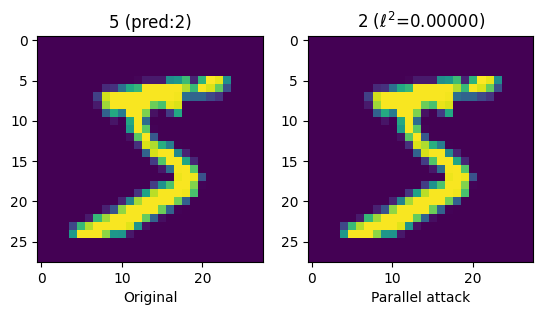

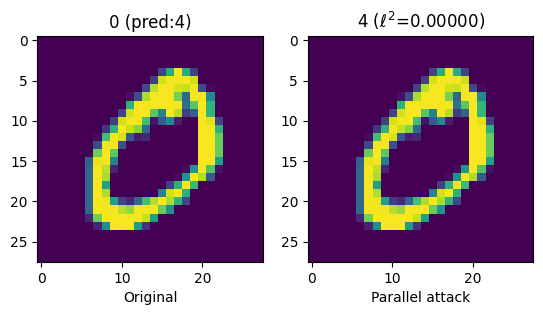

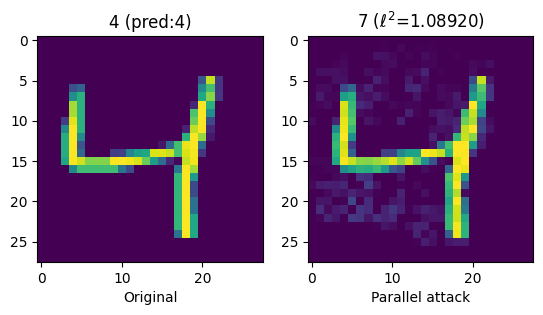

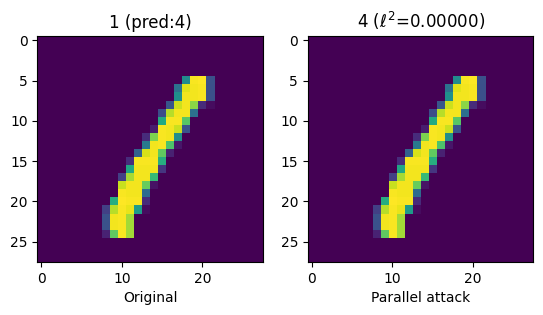

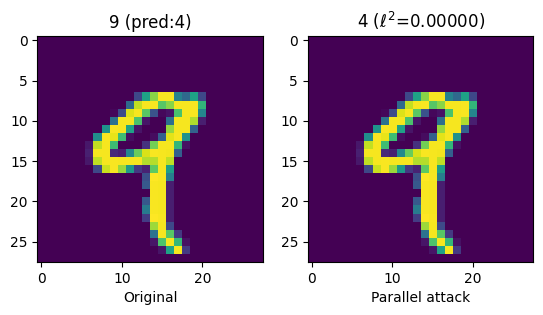

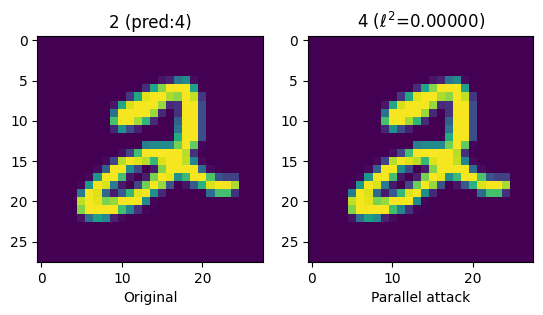

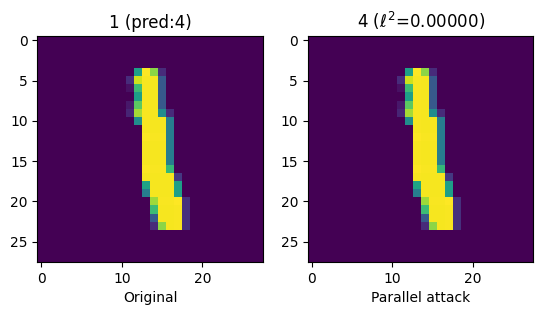

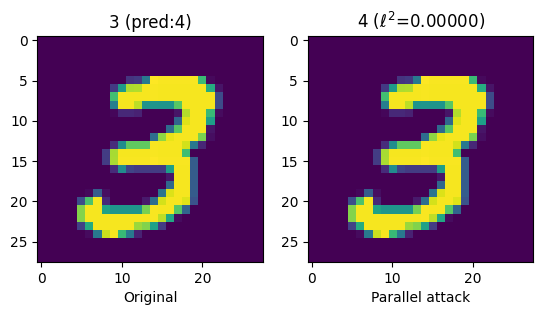

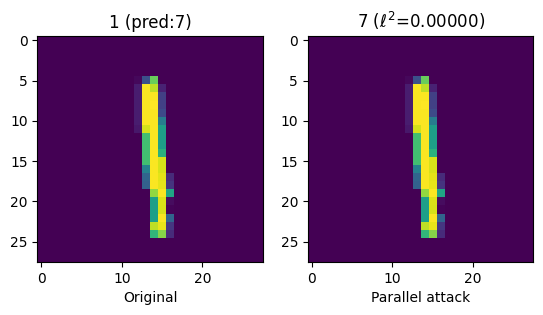

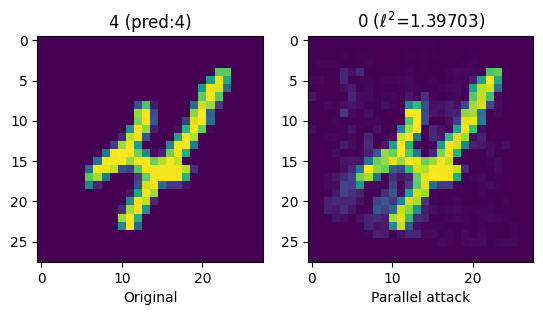

In [6]:
import matplotlib.pyplot as plt

labels = [0,1,2,3,4,5,6,7,8,9]
for i in range(len(x_train_mnist)):
    f, ax = plt.subplots(1,2)

    perturbation = np.linalg.norm(x_train_mnist[[i]] - x_train_mnist_adv[[i]])

    ax[0].set_title(f'{labels[np.argmax(y_train_mnist[[i]])]} (pred:{labels[np.argmax(classifier.predict(x_train_mnist[i]))]})')
    ax[0].imshow(x_train_mnist[i].transpose(1,2,0))
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'{labels[np.argmax(classifier.predict(x_train_mnist_adv[i]))]} ($\\ell ^{2}$={perturbation:.5f})')
    ax[1].imshow(x_train_mnist_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Parallel attack')

In [8]:
np.sum(is_robust) == 0

8

In [22]:
np.max(np.abs(x_train_mnist_adv - x_train_mnist))

0.29603755

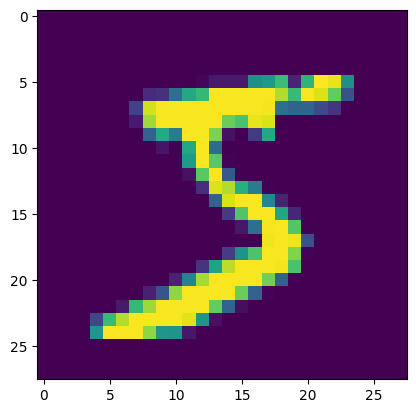

In [23]:
import matplotlib.pyplot as plt
plt.imshow(x_train_mnist[0].transpose(1,2,0))